# Dialogue with MNIST

In [1]:
import sys, os
sys.path.append(os.path.join(".", "ParlAI"))
from parlai.core.agents import Agent
from parlai.core.params import ParlaiParser
from parlai.core.worlds import create_task

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class VanillaAgent(Agent):
    # initialize by setting id
    def __init__(self, opt):
        self.id = 'CNN_Seq'
        
    # store observation for later, return it unmodified
    def observe(self, observation):
        self.observation = observation
        return observation
    
    def act(self):
        reply = {'id': self.id}
        if 'labels' in self.observation:
            reply['text'] = ', '.join(self.observation['labels'])
        else:
            reply['text'] = "I don't know."
        return reply

In [3]:
def parley_verbose(world, verbose=False):
    teacher = world.agents[0]
    agent = world.agents[1]
    def create_verbose_parley():
        teacher_action = teacher.act()
        print("Teacher Question:  {}".format(teacher_action['text']))
        plt.imshow(teacher_action['image'])
        plt.show()
        # student observation
        agent.observe(teacher_action)

        # student action
        student_action = agent.act()
        print("Student Answer: {}".format(student_action['text']))
        # teacher observe action
        teacher.observe(student_action)
        
    if verbose:
        return create_verbose_parley
    return world.parley

2020-08-04 09:23:32,646 INFO     | creating task(s): mnist_qa
loading: /home/karen/proj/parlAI_tutorial/ParlAI/data/mnist/train/labels.json
Teacher Question:  Which number is in the image?


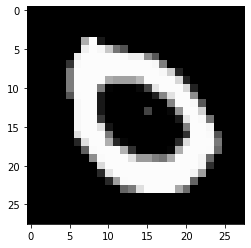

Student Answer: 0, zero


In [4]:
parser = ParlaiParser()
opt, _ = parser.parse_and_process_known_args()
num_interactions = 1
opt["task"] = 'mnist_qa' # adding the task 
agent = VanillaAgent(opt)
world = create_task(opt, agent)
parley = parley_verbose(world, True)
for _ in range(num_interactions):
    parley()

## Training Basic Model

In [5]:
from parlai.scripts.train_model import TrainLoop
opt['load_from_checkpoint'] = False
opt['model_file'] = "mnist_tutorial_1"
opt['datapath'] = "mnist_tutorial"
opt['num_epochs'] = 10
opt['max_train_time'] = 10
opt['log_every_n_secs'] = 10
opt['validation_every_n_secs'] = 10
opt['save_every_n_secs'] = 10
opt['validation_every_n_epochs'] = 10
opt['validation_metric'] = 'loss'
opt['tensorboard_log'] = False
opt['display_examples'] = False
opt['cap_num_predictions'] = 1

train_loop = TrainLoop(opt, external_agent=agent)
train_loop.train()

2020-08-04 09:23:33,034 INFO     | creating task(s): mnist_qa
loading: mnist_tutorial/mnist/train/labels.json
2020-08-04 09:23:33,315 INFO     | training...
2020-08-04 09:23:33,320 INFO     | max_train_time elapsed:10.086979866027832s
2020-08-04 09:23:33,326 INFO     | creating task(s): mnist_qa
loading: mnist_tutorial/mnist/valid/labels.json
2020-08-04 09:23:33,354 INFO     | running eval: valid
2020-08-04 09:23:37,868 INFO     | eval completed in 4.51s
2020-08-04 09:23:37,868 REPORT   | valid:
{"accuracy": 0, "bleu-4": 0, "exs": 10000, "f1": 0}

2020-08-04 09:23:37,870 INFO     | creating task(s): mnist_qa
loading: mnist_tutorial/mnist/test/labels.json
2020-08-04 09:23:37,967 INFO     | running eval: test
2020-08-04 09:23:42,201 INFO     | eval completed in 4.23s
2020-08-04 09:23:42,202 REPORT   | test:
{"accuracy": 0, "bleu-4": 0, "exs": 10000, "f1": 0}



({'exs': SumMetric(1e+04),
  'accuracy': ExactMatchMetric(0),
  'f1': F1Metric(0),
  'bleu-4': BleuMetric(0)},
 {'exs': SumMetric(1e+04),
  'accuracy': ExactMatchMetric(0),
  'f1': F1Metric(0),
  'bleu-4': BleuMetric(0)})

## Building Model From Scratch

In [6]:
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

### Modules

In [7]:
class CNN(nn.Module):
    def __init__(self, img_embedding_size=50):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, img_embedding_size)
        self.fc2 = nn.Linear(img_embedding_size, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [14]:
from parlai.core.torch_ranker_agent import TorchRankerAgent
from parlai.core.torch_image_agent import TorchImageAgent
from torchvision.transforms import ToTensor

class MNIST_Seq(TorchRankerAgent, TorchImageAgent):
    def __init__(self, opt, shared=None):
        """
        Set up model
        """
        super().__init__(opt, shared)
        self.id = "MNIST_qa"
        self.opt = opt
        return
    
#     def init_optim(self, params, optim_states=None):
#         return

    def _dummy_batch(self, batchsize: int, maxlen: int):
        """
        Override to include image feats.
        """
        b = super()._dummy_batch(batchsize, maxlen)
        image = torch.ones(batchsize, self.image_features_dim).cuda()
        if self.n_image_channels > 1:
            image = image.unsqueeze(1).repeat(1, self.n_image_channels, 1)
        if self.fp16:
            image = image.half()
        return Batch(
            text_vec=b.text_vec,
            label_vec=b.label_vec,
            image=image,
            personalities=torch.ones(batchsize, self.opt['embedding_size']).cuda(),
        )

    def _build_candidates(self, batch, source, mode):
#         cand, vecs, inds = super()._build_candidates(batch, source, mode)
        def _map(s):
            try:
                return int(s)
            except:
                return 0
        cands = torch.LongTensor([_map(l) for l in batch.labels if _map(l) is not None])
        cand_vecs = cands.unsqueeze(-1)
        label_inds = cands
        return (batch.labels, cand_vecs, label_inds)
    
    def build_model(self, states=None):
        """Initialize the model, override to change model setup
        """
        # Determine Tokenizer
        model = CNN(self.opt["embedding_size"])
        return model
        
    def batchify(self, *args, **kwargs):
        """
        Override batchify options for seq2seq.
        """
        kwargs['sort'] = True  # need sorted for pack_padded
        return super().batchify(*args, **kwargs)
    
    def score_candidates(self, batch, cand_vecs, cand_encs=None):
        # Image features
        batch = self.batchify_image_features(batch)
        x = self.model(batch.image)
        return x
    
    def batchify_image_features(self, batch):
        """
        Format and return the batched image features.

        Image features represented by tensors will set to the right type.
        """
        if type(batch.image) == list and any(b is not None for b in batch):
            images = []
            for img in batch.image:
                if not isinstance(img, torch.Tensor):
                    img = img.convert('L')
                    img = ToTensor()(img)
                images.append(img)
            images = torch.stack(images)
            batch.image = images
        return batch

    def _model_input(self, batch):
        return (batch.text_vec, batch.image)

In [21]:
parser = ParlaiParser()
opt, _ = parser.parse_and_process_known_args()
num_interactions = 1000
opt["task"] = 'mnist_qa' # adding the task 
opt['load_from_checkpoint'] = False
opt['model_file'] = "mnist_model"
opt['datapath'] = "mnist_tutorial2"
opt['num_epochs'] = 10
opt['max_train_time'] = 10
opt['log_every_n_secs'] = 10
opt['validation_every_n_secs'] = 10
opt['save_every_n_secs'] = 10
opt['validation_every_n_epochs'] = 10
opt['validation_metric'] = 'loss'
opt['tensorboard_log'] = False
opt['display_examples'] = False
opt['no_cuda'] = True
opt['history_size'] = 2
opt['truncate'] = 2
opt['rank_candidates'] = True
opt['eval_candidates'] = "inline"
opt['candidates'] = "fixed"
opt['fixed_candidates_path'] = "candidates.txt"
opt['ignore_bad_candidates'] = True
opt['encode_candidate_vecs'] = False
opt['embedding_size'] = 50
opt['fixed_candidate_vecs'] = 'reuse'
opt['learningrate'] = 5e-5
opt['optimizer'] = 'sgd'
opt['momentum'] = 0
opt['lr_scheduler'] = 'fixed'
opt['momentum'] = 0
opt['max_lr_steps'] = -1
opt['image_features_dim'] = 50
opt['image_encoder_num_layers'] = 1
opt['n_image_tokens'] = 1
opt['n_image_channels'] = 1
opt['cap_num_predictions'] = 1
opt['display_examples'] = True

opt['gpu'] = -1
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
agent = MNIST_Seq(opt)
world = create_task(opt, agent)
parley = parley_verbose(world, False)

for _ in range(num_interactions):
    parley()

2020-08-04 09:32:21,857 INFO     | loading dictionary from mnist_model.dict
2020-08-04 09:32:21,858 INFO     | num words = 4
2020-08-04 09:32:21,860 INFO     | Total parameters: 21,840 (21,840 trainable)
2020-08-04 09:32:21,861 INFO     | Loading existing model parameters from mnist_model
2020-08-04 09:32:21,863 INFO     | Loading fixed candidate set from candidates.txt
2020-08-04 09:32:21,864 INFO     | Loading fixed candidate set vectors from mnist_model.candidates.vecs
2020-08-04 09:32:21,866 INFO     | creating task(s): mnist_qa
loading: mnist_tutorial2/mnist/train/labels.json


In [22]:
from parlai.scripts.train_model import TrainLoop


train_loop = TrainLoop(opt, external_agent=agent)
train_loop.train()

2020-08-04 09:32:25,255 INFO     | building dictionary first...
2020-08-04 09:32:25,257 INFO     | creating task(s): mnist_qa
loading: mnist_tutorial2/mnist/train/labels.json
2020-08-04 09:32:25,462 INFO     | training...
2020-08-04 09:32:25,481 INFO     | max_train_time elapsed:10.215430974960327s
2020-08-04 09:32:25,488 INFO     | creating task(s): mnist_qa
loading: mnist_tutorial2/mnist/valid/labels.json
2020-08-04 09:32:25,517 INFO     | running eval: valid
[mnist_qa]: Which number is in the image?
[label_candidates]: 0|six|nine|four|3|... (5 of 20 shown)
[eval_labels]: 3|three
   [metrics]: {'loss': AverageMetric(2.719), 'rank': AverageMetric(4), 'mrr': AverageMetric(0.25)}
   [MNIST_qa]: 3
   [text_candidates]: 3
- - - - - - - END OF EPISODE - - - - - - - - - -
~~
{'exs': SumMetric(1), 'accuracy': ExactMatchMetric(1), 'f1': F1Metric(1), 'bleu-4': BleuMetric(1e-09), 'hits@1': AverageMetric(1), 'hits@5': AverageMetric(1), 'hits@10': AverageMetric(1), 'hits@100': AverageMetric(1), '

({'exs': SumMetric(1e+04),
  'accuracy': ExactMatchMetric(1),
  'f1': F1Metric(1),
  'bleu-4': BleuMetric(1e-09),
  'hits@1': AverageMetric(1),
  'hits@5': AverageMetric(1),
  'hits@10': AverageMetric(1),
  'hits@100': AverageMetric(1),
  'loss': AverageMetric(1.696),
  'rank': AverageMetric(3.251),
  'mrr': AverageMetric(0.648),
  'exps': GlobalTimerMetric(588.5),
  'ltpb': GlobalAverageMetric(2),
  'ltps': GlobalTimerMetric(1177),
  'ctpb': GlobalAverageMetric(2),
  'ctps': GlobalTimerMetric(1177),
  'tpb': GlobalAverageMetric(4),
  'tps': GlobalTimerMetric(2354),
  'lr': GlobalAverageMetric(5e-05),
  'total_train_updates': GlobalFixedMetric(1.518e+04)},
 {'exs': SumMetric(1e+04),
  'accuracy': ExactMatchMetric(1),
  'f1': F1Metric(1),
  'bleu-4': BleuMetric(1e-09),
  'hits@1': AverageMetric(1),
  'hits@5': AverageMetric(1),
  'hits@10': AverageMetric(1),
  'hits@100': AverageMetric(1),
  'loss': AverageMetric(1.718),
  'rank': AverageMetric(3.291),
  'mrr': AverageMetric(0.6402),
  